# Style transfer

In [1]:
import os
from PIL import Image
import torch
from torch import nn
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Методы для загрузки изображения и преобразования его в 1-мерный тензор, а также обратного преобразования из тензора в изображение. В данном случае будем использовать разрешение $650\times512$.

In [3]:
loader = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop((512, 650)),
    transforms.ToTensor()
])

def load_img(fname):
    img = Image.open(fname)
    return loader(img).to(DEVICE)

def tensor2image(x):
    return transforms.ToPILImage()(x.detach().cpu())

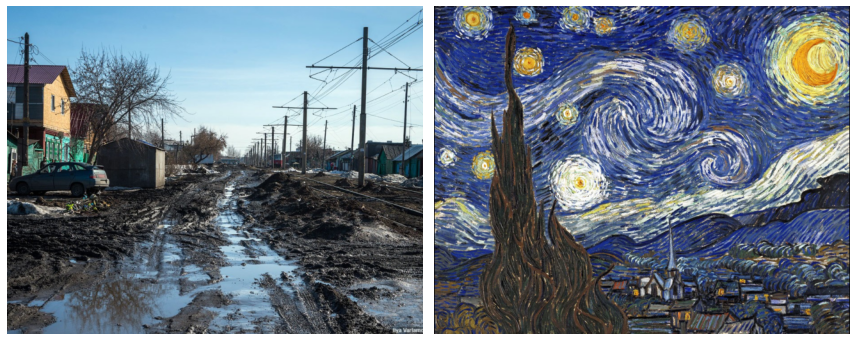

In [4]:
content_image = load_img(os.path.join(os.getcwd(), 'data', 'content', 'omsk2.jpeg'))
style_image = load_img(os.path.join(os.getcwd(), 'data', 'style', 'van_gogh.webp'))

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
axes[0].imshow(tensor2image(content_image))
axes[1].imshow(tensor2image(style_image))
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

*Style transfer* будем осуществлять следующим образом -- будем изменять исходное изображение так, чтобы его представление на некоторых сверточных слоях как можно меньше отличалось как от исходного изображения (`content_loss`), так и от изображения с копируемым стилем (`style_loss`). В качестве loss-функции будем использовать `mse_loss`, для стилистического сравнения будем сначала рассчитывать матрицы Грама.

In [5]:
def calculate_content_loss(x, target):
    return nn.functional.mse_loss(x, target.detach())

def gram_matrix(x):
    a, b, c = x.size()
    features = x.view(a, b * c)
    G = torch.mm(features, features.t())
    return G.div(a * b * c)

def calculate_style_loss(x, target):
    Gx = gram_matrix(x)
    Gt = gram_matrix(target.detach())
    return nn.functional.mse_loss(Gx, Gt)

Следуя статье, будем использовать предобученную сеть VGG19. Ниже реализован модуль для решения поставленнной задачи. При инициализации ему передаются порядковые индексы свёрточных слоёв, представления изображений в которых будут учитываться при расчёте `content_loss` и `style_loss`, а также соответствующие веса.

In [6]:
class StyleContentModel(nn.Module):
    def __init__(self, content_indices, content_weights,
                 style_indices, style_weights):
        super().__init__()
        # get pretrained VGG model
        vgg = models.vgg19(pretrained=True).features.to(DEVICE)
        self.vgg = nn.Sequential()

        # find absolute indices of layers needed for calculating content
        # and style losses
        self.content_inds = []
        self.style_inds = []
        conv_count = 0
        for name, layer in vgg.named_children():
            ci = None
            si = None
            if isinstance(layer, nn.Conv2d):
                if conv_count in content_indices:
                    ci = content_indices.index(conv_count)
                if conv_count in style_indices:
                    si = style_indices.index(conv_count)
                conv_count += 1
            elif isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)  # default inplace ReLU breaks backprop
            self.vgg.add_module(name, layer)
            self.content_inds.append(ci)
            self.style_inds.append(si)
        # lists will look like [None, None, 0, None, 1, ...]

        # do not update vgg weights
        self.vgg.eval()
        for parameter in self.vgg.parameters():
            parameter.requires_grad_(False)

        # store weights for calculating loss
        self.content_weights = content_weights
        self.style_weights = style_weights

        # VGG requires input normalization
        self.normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])

    def forward(self, x, tc, ts):
        # normalize inputs
        x = self.normalizer(x)
        tc = self.normalizer(tc)
        ts = self.normalizer(ts)

        content_losses = []
        style_losses = []

        # go through VGG layers
        for i, layer in enumerate(self.vgg.children()):
            x = layer(x)
            tc = layer(tc)
            ts = layer(ts)

            # update content and style losses if needed
            if self.content_inds[i] is not None:
                w = self.content_weights[self.content_inds[i]]
                content_losses.append(
                    w * calculate_content_loss(x, tc))
            if self.style_inds[i] is not None:
                w = self.style_weights[self.style_inds[i]]
                style_losses.append(w * calculate_style_loss(x, ts))

        return (torch.sum(torch.stack(content_losses)),
                torch.sum(torch.stack(style_losses)))


Вспомогательная функция для получения изображения с новым стилем.

In [7]:
def style_transfer(content_image, style_image,
                   content_layer_inds, style_layer_inds,
                   content_loss_weights, style_loss_weights,
                   num_iter=100, **kwargs):
    def closure():
        with torch.no_grad():
            input_image.clamp_(0, 1)
        optimizer.zero_grad()
        content_loss, style_loss = model.forward(input_image,
                                                 content_image, style_image)
        loss = content_loss + style_loss
        loss.backward()
        iter_count[0] += 1

        # display progress
        s = '\rIteration: {}, content_loss: {:.2e}, style_loss: {:.2e}'.format(
            iter_count[0], content_loss.item(), style_loss.item()
        )
        print(s, end='')
        return loss

    input_image = content_image.clone()  # use original (content) image as initial result
    input_image.requires_grad_(True)
    model = StyleContentModel(content_layer_inds, content_loss_weights,
                              style_layer_inds, style_loss_weights)
    optimizer = torch.optim.LBFGS(params=[input_image], **kwargs)  # works faster then Adam
    iter_count = [0]  # workaround, LBFGS performs several evaluations per step
    while iter_count[0] < num_iter:
        optimizer.zero_grad()
        optimizer.step(closure=closure)
    print()

    with torch.no_grad():
        input_image.clamp_(0, 1)
    return tensor2image(input_image)

Преобразуем наше изображение к требуемому стилю. Если следовать обозначениям из статьи, то для `style_loss` мы используем слои `[conv_1.1, conv_2.1, conv_3.1, conv_4.1, conv_5.1]`, а для `content_loss` -- только `conv_5.2`.

In [8]:
output = style_transfer(
    content_image=content_image,
    style_image=style_image,
    content_layer_inds=[13],
    content_loss_weights=[1.0],
    style_layer_inds=[0, 2, 4, 8, 12],
    style_loss_weights=[2e4] * 5,
    num_iter=500,
)

Iteration: 500, content_loss: 1.55e+00, style_loss: 1.24e+00


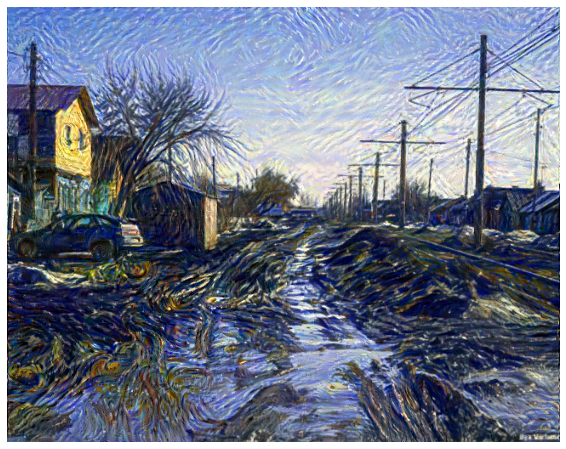

In [9]:
plt.figure(figsize=(12, 8))
plt.imshow(output)
plt.axis('off');